# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file.


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.**
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state.
* **Discrete** means that we have a **finite set of states.** The maze has a finite set
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [709]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [710]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

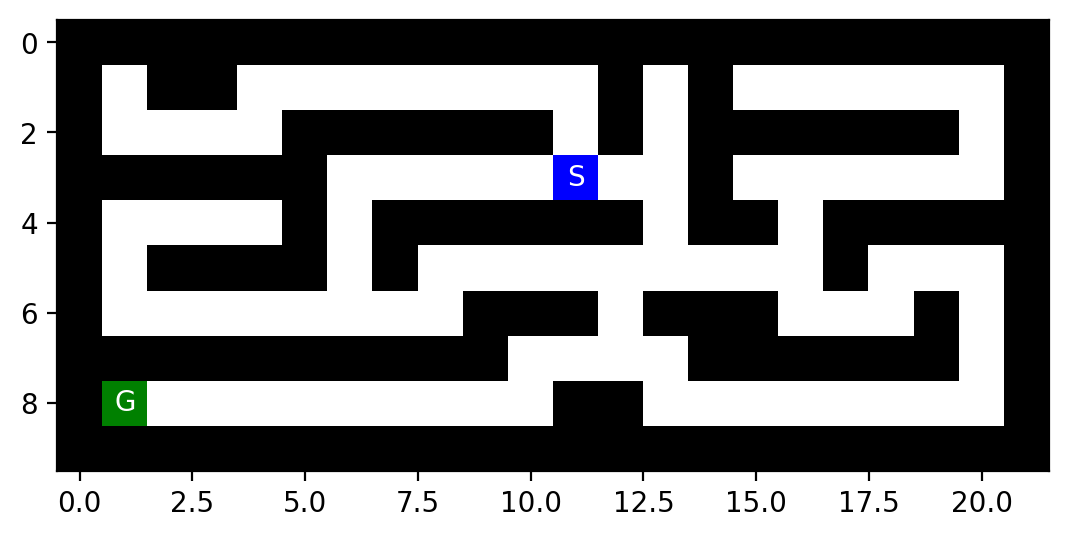

In [711]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [712]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [713]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [714]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [715]:
# Your answer goes here

# Task 1: Defining the Search Problem and Problem Size

## 1. Initial State (Trạng thái ban đầu)
- Vị trí xuất phát của tác tử (agent) trong mê cung, ký hiệu bằng **S**.  
- Biểu diễn dưới dạng tọa độ hàng và cột:  

$$
S_0 = (row_S, col_S)
$$

## 2. Actions (Các hành động)
- Ở mỗi trạng thái, tác tử có thể thực hiện một trong bốn hành động:

$$
A = \{Up, Down, Left, Right\}
$$

- **Điều kiện**: chỉ thực hiện hành động nếu ô tiếp theo:
  - Không phải tường (`#`).
  - Nằm trong phạm vi mê cung.

## 3. Transition Model (Mô hình chuyển trạng thái)
- Mô hình xác định trạng thái kế tiếp sau khi thực hiện hành động.  

Với trạng thái hiện tại \((r, c)\):

- **Up** → \((r-1, c)\)  
- **Down** → \((r+1, c)\)  
- **Left** → \((r, c-1)\)  
- **Right** → \((r, c+1)\)  

Môi trường **rời rạc, xác định và biết trước**, nên cùng một hành động tại cùng một trạng thái sẽ luôn cho kết quả giống nhau.

## 4. Goal State (Trạng thái đích)
- Vị trí đích trong mê cung, ký hiệu bằng **G**.  
- Biểu diễn dưới dạng tọa độ:  

$$
s_{goal} = (row_G, col_G)
$$

- Thuật toán dừng khi tác tử đạt tới trạng thái này.

## 5. Path Cost (Chi phí đường đi)
- Mỗi bước di chuyển có chi phí bằng **1**.  
- Tổng chi phí đường đi từ S đến G là số bước di chuyển:

$$
Cost(path) = \sum_{i=1}^{n} 1 = n
$$

Trong đó **n** là số hành động (số bước) trên đường đi.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [716]:
# Your answer goes here

### $n$ : State space size (kích thước không gian trạng thái)  
- Là **tổng số trạng thái có thể đi được** trong mê cung (tất cả các ô không phải tường).   
- **Ví dụ**: mê cung 5x5 có 25 ô, nếu 7 ô là tường thì $n = 18$  

### $d$ : Depth of the optimal solution (độ sâu của nghiệm tối ưu)  
- Là **số bước ngắn nhất** từ điểm Start (S) đến Goal (G).  
- Nếu mỗi bước di chuyển có chi phí 1, thì $d$ chính là **độ dài đường đi tối ưu**.  
- **Cách tìm**: chạy BFS (Breadth-First Search) từ S đến G → BFS sẽ cho đường đi ngắn nhất, từ đó lấy số bước.  

### $m$ : Maximum depth of tree (độ sâu lớn nhất của cây tìm kiếm)  
- Đây là **độ sâu lớn nhất** mà thuật toán có thể đi xuống trong trường hợp xấu nhất.  
- Nếu **không cho lặp lại trạng thái**, thì tối đa đi qua tất cả ô khả dĩ:  
  $m = n - 1$  
- Nếu **cho lặp lại**, thì có thể vô hạn, nhưng thường ta giới hạn nên lấy gần đúng:  
  $m \approx n - 1$  

### $b$ : Maximum branching factor (hệ số phân nhánh tối đa)  
- Là số **trạng thái con nhiều nhất** có thể sinh ra từ một trạng thái.  
- Trong mê cung, mỗi ô có tối đa **4 ô kề** (Up, Down, Left, Right).  
- Vì có tường và biên, nên thường $b = 2, 3$ hoặc $4$.  
- **Cách tính**: duyệt tất cả ô có thể đi được, đếm số hàng xóm hợp lệ, lấy giá trị lớn nhất.  

## Tóm gọn cách xác định
- $n$: đếm số ô không phải tường.  
- $d$: chạy BFS để lấy số bước từ S đến G.  
- $m$: thường $= n - 1$ (đi qua hết các ô một lần).  
- $b$: tìm ô có nhiều hàng xóm nhất, thường $ \leq 4$.  


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking.
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

Đây là đường đi của thuật toán bfs


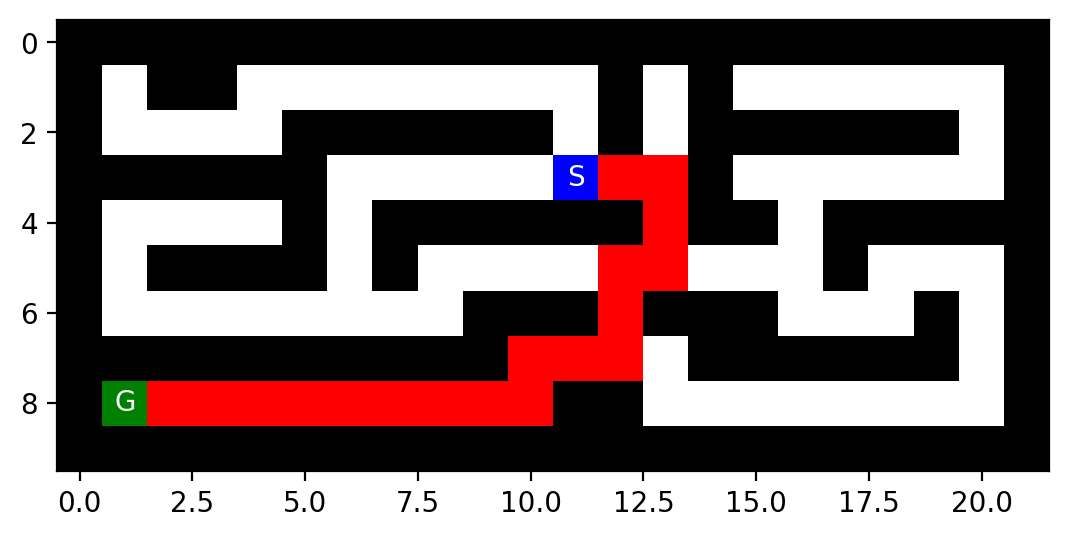

path_cost:  19 
nodes_expanded:  92 
max_depth:  19 
max_frontier_size:  8

Đây là đường đi của thuật toán dfs


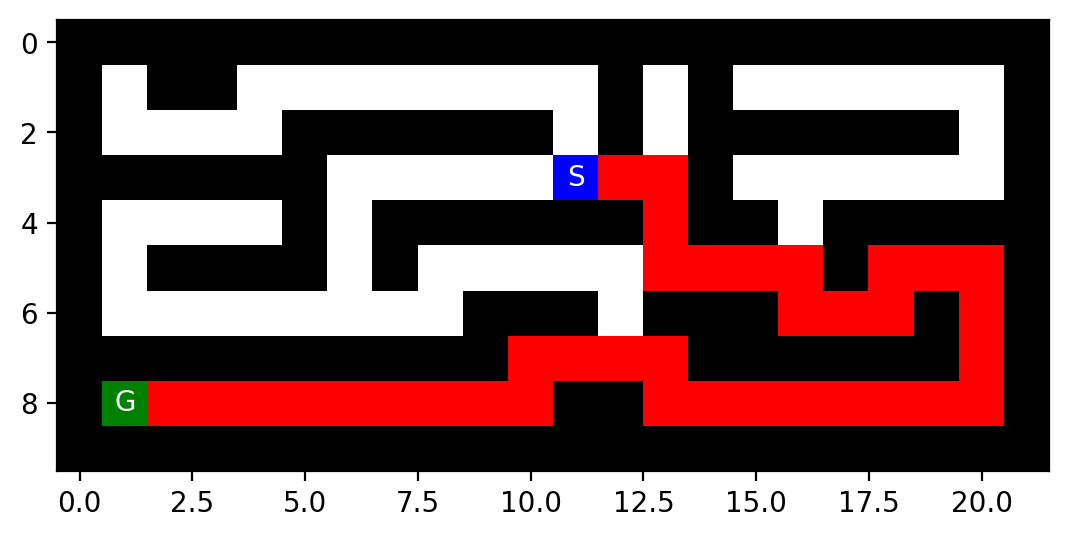

path_cost:  37 
nodes_expanded:  38 
max_depth:  37 
max_frontier_size:  7


In [717]:

# Your code goes here
from collections import deque
import numpy as np

def bfs(maze, start, goal):
    # khởi tạo root node
    root = Node(start, None, None, 0)
    frontier = deque([root])          # hàng đợi (FIFO)
    reached = {start}                 # tập các state đã gặp
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    while frontier:
        node = frontier.popleft()
        nodes_expanded += 1
        max_depth = max(max_depth,node.cost)
        if node.pos == goal:
            path = node.get_path_from_root()
            return{
                "solution": [n.pos for n in  path],
                "path_cost": node.cost,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth,
                "max_frontier_size": max_frontier_size
            }
        # duyệt các action (4 hướng)
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
          r,c = node.pos[0] + dr, node.pos[1] + dc
          if maze[r,c] != "X":
            child_pos = (r,c)
            if child_pos not in reached:
              child = Node(child_pos, node, (dr,dc), node.cost + 1)
              frontier.append(child)
              reached.add(child_pos)
        max_frontier_size = max(max_frontier_size, len(frontier))
    return None  # không tìm thấy

def dfs(maze, start, goal):
    root = Node(start, None, None, 0)
    frontier = [root]     # stack (LIFO)
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    while frontier:
        node = frontier.pop()
        nodes_expanded += 1
        max_depth = max(max_depth, node.cost)
        if node.pos == goal:
          path = node.get_path_from_root()
          return {
              "solution": [n.pos for n in path],
              "path_cost": node.cost,
              "nodes_expanded": nodes_expanded,
              "max_depth": max_depth,
              "max_frontier_size": max_frontier_size
          }
        # duyệt 4 hướng
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
          r,c = node.pos[0] + dr, node.pos[1] + dc
          if maze[r,c] != "X":
            child_pos = (r,c)
            ancestor = node
            cycle = False
            while ancestor is not None:
              if ancestor.pos == child_pos:
                cycle = True
                break
              ancestor = ancestor.parent
            if cycle:
              continue
            child = Node(child_pos, node, (dr,dc), node.cost + 1)
            frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))
    return None




def mark_solution_on_maze(maze, solution, explored=None):
    """
    Đánh dấu đường đi (solution) và các ô đã thăm (explored) vào maze.
    - solution: list các tọa độ [(x,y), ...] tạo thành đường đi cuối cùng.
    - explored: list các tọa độ đã expand trong quá trình tìm kiếm (có thể None).
    """
    maze_copy = np.copy(maze)

    # Đánh dấu các ô đã mở rộng (nếu có)
    if explored is not None:
        for r, c in explored:
            if maze_copy[r, c] == ' ':   # chỉ đánh dấu nếu là ô trống
                maze_copy[r, c] = '.'

    # Đánh dấu đường đi
    for r, c in solution:
        if maze_copy[r, c] not in ['S', 'G']:  # giữ nguyên S, G
            maze_copy[r, c] = 'P'

    return maze_copy


def show_result_to_maze(name_algorithm, maze, start, goal):
  result = name_algorithm(maze,start,goal)
  maze_result = mark_solution_on_maze(
      maze,
      result['solution'],
      explored=result.get('explored')
  )
  mh.show_maze(maze_result)

start = mh.find_pos(maze, "S")
goal = mh.find_pos(maze, "G")
print("Đây là đường đi của thuật toán bfs")
show_result_to_maze(bfs, maze,start,goal)
result_bfs = bfs(maze,start,goal)
print("path_cost: ", result_bfs['path_cost'],
      "\nnodes_expanded: ", result_bfs["nodes_expanded"],
      "\nmax_depth: ", result_bfs["max_depth"],
      "\nmax_frontier_size: ", result_bfs["max_frontier_size"])
print("\nĐây là đường đi của thuật toán dfs")
show_result_to_maze(dfs, maze,start,goal)
result_dfs = dfs(maze,start,goal)
print("path_cost: ", result_dfs['path_cost'],
      "\nnodes_expanded: ", result_dfs["nodes_expanded"],
      "\nmax_depth: ", result_dfs["max_depth"],
      "\nmax_frontier_size: ", result_dfs["max_frontier_size"])

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [718]:
# Discussion

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [719]:
# Discussion
"""
      Đối với BFS (không thể dùng cycle thay thế reached)
      . BFS mở rộng từng nút theo từng tầng
      . Nếu không có reached, thì cùng 1 trạng thái có thể bị đưa vào hàng đợi (queue) nhiều lần bởi các đường đi khác nhau
      . Do đó:
        . Với đồ thị hữu hạn khi dùng cycle BFS vẫn có lời giải nhưng sẽ rất tốn bộ nhớ khi qua lại 1 trạng thái nhiều lần ở các con đường khác nhau
        . Với đồ thị vô hạn hoặc có chu trình quay lại chính nó, BFS sẽ không bao giờ dừng vì cứ sinh ra lại trạng thái cũ
"""

"""
      Đối với DFS (Có thể sử dụng cycle để thay thế reached)
      . Ở đoạn code trên sử dụng biến ancestor (tổ tiên) gán cho node ở vị trí hiện tại
      . Nếu vị trí của ancestor trùng với vị trí của child (ancestor.pos == childe.pos) nghĩa là node con này đã có trên đường đi
        . Cycle = True và ta sẽ bỏ qua node con đó
      . Nếu vị trí của ancestor không trùng với vị trí của child (ancestor.pos != child.pos) thì ancestor sẽ được gán lại node cha của nó (ancestor = ancestor.parent)
        . Lặp đi lặp lại tới khi ancestor = root
        . Nếu ancestor vẫn không trùng với child thì ancestor.parent = None và kết thúc vòng lặp
        . Sau đó node con sẽ được được mở rộng và thêm vào đường đi
"""

'\n      Đối với DFS (Có thể sử dụng cycle để thay thế reached)\n      . Ở đoạn code trên sử dụng biến ancestor (tổ tiên) gán cho node ở vị trí hiện tại\n      . Nếu vị trí của ancestor trùng với vị trí của child (ancestor.pos == childe.pos) nghĩa là node con này đã có trên đường đi\n        . Cycle = True và ta sẽ bỏ qua node con đó\n      . Nếu vị trí của ancestor không trùng với vị trí của child (ancestor.pos != child.pos) thì ancestor sẽ được gán lại node cha của nó (ancestor = ancestor.parent)\n        . Lặp đi lặp lại tới khi ancestor = root\n        . Nếu ancestor vẫn không trùng với child thì ancestor.parent = None và kết thúc vòng lặp\n        . Sau đó node con sẽ được được mở rộng và thêm vào đường đi\n'

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

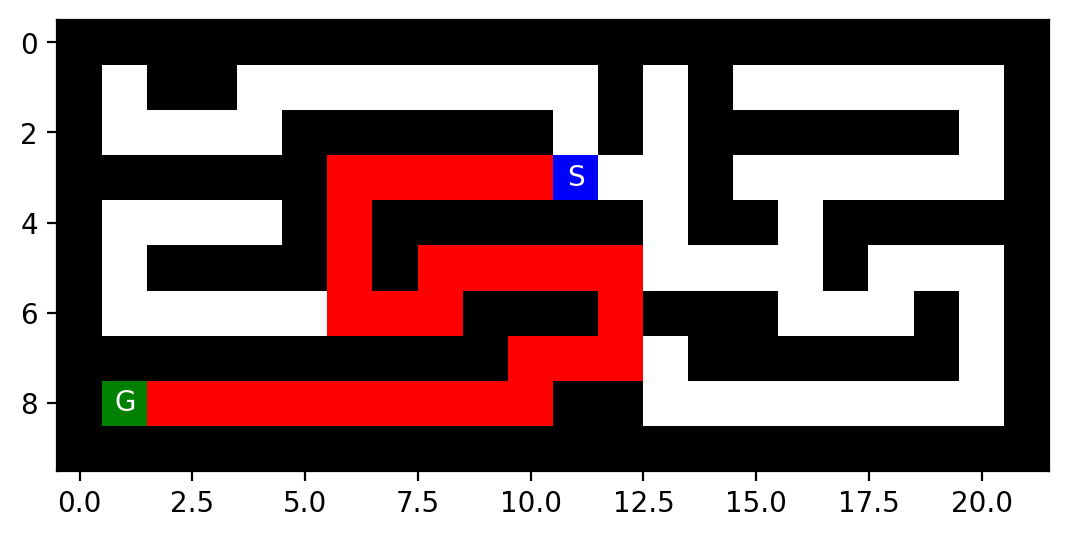

Path cost: 29
Nodes expanded: 40
Max depth: 40
Max frontier size: 5


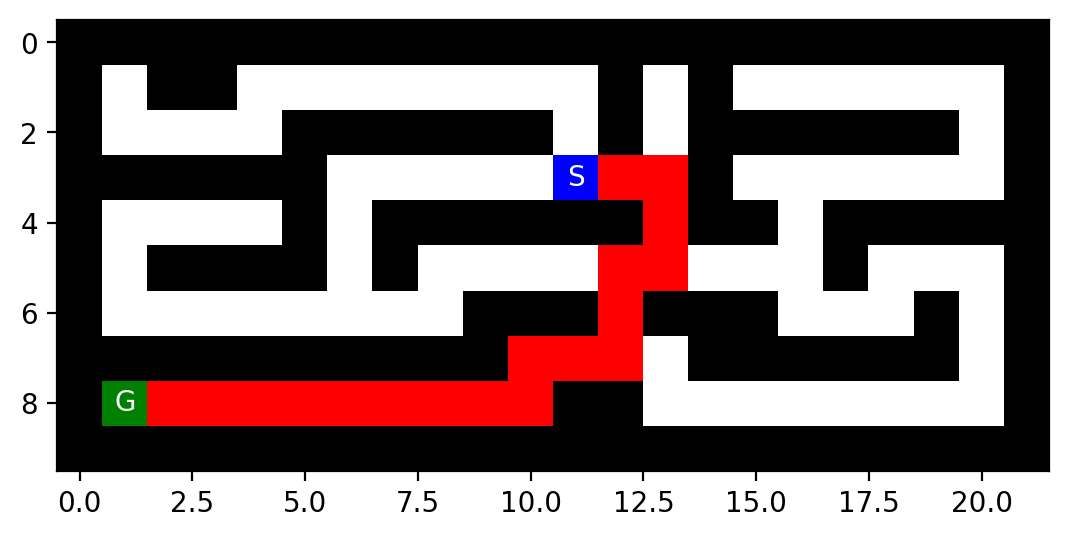

Path cost: 19
Nodes expanded: 54
Max depth: 19
Max frontier size: 7


In [720]:
# Your code goes here
import maze_helper as mh
import heapq
import copy

with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
start = mh.find_pos(maze, "S")
goal = mh.find_pos(maze, "G")


def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def A_Star(maze, start, goal):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), start))
    g_score = {start: 0}
    parent = {start: None}
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    directions = [(1,0), (-1,0), (0,1), (0,-1)]
    while frontier:
        _, current = heapq.heappop(frontier)
        if current in visited:
            continue
        visited.add(current)
        nodes_expanded += 1
        max_depth = max(max_depth, g_score[current])
        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return {
                "solution": path,
                "path_cost": len(path)-1,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth,
                "max_frontier_size": max_frontier_size
            }
        r, c = current
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            neighbor = (nr, nc)
            if 0 <= nr < len(maze) and 0 <= nc < len(maze[0]) and maze[nr][nc] != "X":
                temp_g = g_score[current] + 1
                if neighbor not in g_score or temp_g < g_score[neighbor]:
                    g_score[neighbor] = temp_g
                    f_score = temp_g + manhattan_distance(neighbor, goal)
                    heapq.heappush(frontier, (f_score, neighbor))
                    parent[neighbor] = current
        max_frontier_size = max(max_frontier_size, len(frontier))
    return None


def gbfs(maze, start, goal):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), start))
    parent = {start: None}
    visited = set()
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    directions = [(1,0), (-1,0), (0,1), (0,-1)]
    while frontier:
        _, current = heapq.heappop(frontier)
        if current in visited:
            continue
        visited.add(current)
        nodes_expanded += 1
        max_depth = max(max_depth, nodes_expanded)
        if current == goal:
            path = []
            node = current
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return {
                "solution": path,
                "path_cost": len(path)-1,
                "nodes_expanded": nodes_expanded,
                "max_depth": max_depth,
                "max_frontier_size": max_frontier_size
            }
        r, c = current
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            neighbor = (nr, nc)
            if (0 <= nr < len(maze) and 0 <= nc < len(maze[0]) and maze[nr][nc] != "X" and neighbor not in visited):
                parent[neighbor] = current
                heapq.heappush(frontier, (manhattan_distance(neighbor, goal), neighbor))
        max_frontier_size = max(max_frontier_size, len(frontier))
    return None


def show_maze_result(maze, result):
    maze_copy = copy.deepcopy(maze)
    if result is None:
        print("Không tìm thấy đường đi!")
        return
    path = result["solution"]
    for r, c in path[1:-1]:
        maze_copy[r][c] = "P"
    mh.show_maze(maze_copy)
    print("Path cost:", result["path_cost"])
    print("Nodes expanded:", result["nodes_expanded"])
    print("Max depth:", result["max_depth"])
    print("Max frontier size:", result["max_frontier_size"])


result_gbfs = gbfs(maze, start, goal)
show_maze_result(maze, result_gbfs)
result_astar = A_Star(maze, start, goal)
show_maze_result(maze, result_astar)


Are your implementations complete and optimal? What is the time and space complexity?

In [721]:
# Discussion
'''
Chú thích:
- Complete: nghĩa là thuật toán luôn tìm ra một solution nếu solution tồn tại trong không gian tìm kiếm (search space).
- Optimal: nghĩa là thuật toán luôn tìm ra solution tốt nhất, thường là đường đi ngắn nhất hoặc chi phí thấp nhất.
- Heuristic admissible: là ước lượng chi phí từ một nút đến mục tiêu mà không bao giờ đánh giá quá cao so với chi phí thực tế thấp nhất.
- Frontier: là danh sách các nút chưa được mở nhưng đang chờ được kiểm tra.

------> A* <------
- Complete:
    + Có đảm bảo complete vì A* với heuristic Manhattan distance (không bao giờ đánh giá vượt quá chi phí còn lại).

- Optimal:
    + Có tối ưu vì thuật toán A* với heuristic admissible (Manhattan distance) luôn tìm ra đường đi ngắn nhất.

- Time complexity:
    + O(b^d)
        b: là branching factor (số nhánh có thể di chuyển từ mỗi ô).
        d: là chiều sâu của giải pháp.  
    + Thực tế nhờ vào heuristic tốt nên A* thường mở ít node hơn BFS. Nhưng trong worst-case thì vẫn là tăng theo lũy thừa.

- Space complexity:
    + O(b^d), vì phải lưu toàn bộ frontier và visited nodes trong bộ nhớ.

------> GBFS <------
- Complete:
    + Không thể complete được vì GBFS chọn node dựa vào heuristic h(n) mà bỏ qua chi phí đường đi đã đi g(n). Nếu heuristic
    dẫn sai hướng, thuật toán có thể không tìm thấy goal, đặc biệt trong các maze phức tạp, "bẫy".

- Optimal:
    + Không tối ưu vì GBFS không đảm bảo đường đi ngắn nhất vì nó không tính g(n), chỉ theo h(n). GBFS sẽ chỉ luôn lựa chọn h(n) nhỏ nhất để chọn.

- Time complexity:
    + O(b^m) trong worst case.
        b: là branching factor (số nhánh có thể di chuyển từ mỗi ô).
        m là chiều sâu lớn nhất của cây tìm kiếm.

- Space complexity:
    + O(b^m), vì cần lưu frontier và visited nodes tương tự A*, nhưng frontier thường nhỏ hơn nhờ heuristic hướng đến goal.
'''


'\nChú thích:\n- Complete: nghĩa là thuật toán luôn tìm ra một solution nếu solution tồn tại trong không gian tìm kiếm (search space).\n- Optimal: nghĩa là thuật toán luôn tìm ra solution tốt nhất, thường là đường đi ngắn nhất hoặc chi phí thấp nhất.\n- Heuristic admissible: là ước lượng chi phí từ một nút đến mục tiêu mà không bao giờ đánh giá quá cao so với chi phí thực tế thấp nhất.\n- Frontier: là danh sách các nút chưa được mở nhưng đang chờ được kiểm tra.\n\n------> A* <------\n- Complete:\n    + Có đảm bảo complete vì A* với heuristic Manhattan distance (không bao giờ đánh giá vượt quá chi phí còn lại).\n\n- Optimal:\n    + Có tối ưu vì thuật toán A* với heuristic admissible (Manhattan distance) luôn tìm ra đường đi ngắn nhất.\n\n- Time complexity:\n    + O(b^d)\n        b: là branching factor (số nhánh có thể di chuyển từ mỗi ô).\n        d: là chiều sâu của giải pháp.  \n    + Thực tế nhờ vào heuristic tốt nên A* thường mở ít node hơn BFS. Nhưng trong worst-case thì vẫn là tăn

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [722]:
# Your code goes here
import pandas as pd
import matplotlib.pyplot as plt

def load_maze(path_maze):
    with open(path_maze, "r") as f:
        maze_str = f.read()
        maze = mh.parse_maze(maze_str)
        start = mh.find_pos(maze, "S")
        goal = mh.find_pos(maze, "G")
    return maze, start, goal

def run_algorithms(maze, start, goal):
    results = []
    algorithms = {
        "BFS": bfs,
        "DFS": dfs,
        "GBS": gbfs,
        "A*": A_Star
    }

    for name, algo in algorithms.items():
        try:
            result = algo(maze, start, goal)
            if result is None:
                raise ValueError("No solution found")
            results.append({
                "algorithm": name,
                "path cost": result["path_cost"],
                "# of nodes expanded": result["nodes_expanded"],
                "max tree depth": result["max_depth"],
                "max # of nodes in memory": result.get("max_nodes_in_memory", "-"),
                "max frontier size": result["max_frontier_size"]
            })
        except Exception as e:
            results.append({
                "algorithm": name,
                "path cost": "*",
                "# of nodes expanded": "*",
                "max tree depth": "*",
                "max # of nodes in memory": "*",
                "max frontier size": "*"
            })
            print(f"{name} gặp lỗi: {e}")
    return pd.DataFrame(results)


mazes = {
    "Small Maze": "./small_maze.txt",
    "Medium Maze": "./medium_maze.txt"
}

all_results = []

for maze_name, path in mazes.items():
    try:
        maze, start, goal = load_maze(path)
        df = run_algorithms(maze, start, goal)
        df["maze"] = maze_name
        all_results.append(df)
    except Exception as e:
        print(f"Lỗi khi xử lý {maze_name}: {e}")

df_all = pd.concat(all_results, ignore_index=True)
df_all


,algorithm,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size,maze
0,BFS,19,92,19,-,8,Small Maze
1,DFS,37,38,37,-,7,Small Maze
2,GBS,29,40,40,-,5,Small Maze
3,A*,19,54,19,-,7,Small Maze
4,BFS,68,270,68,-,8,Medium Maze
5,DFS,130,147,130,-,9,Medium Maze
6,GBS,152,158,158,-,8,Medium Maze
7,A*,68,221,68,-,8,Medium Maze


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

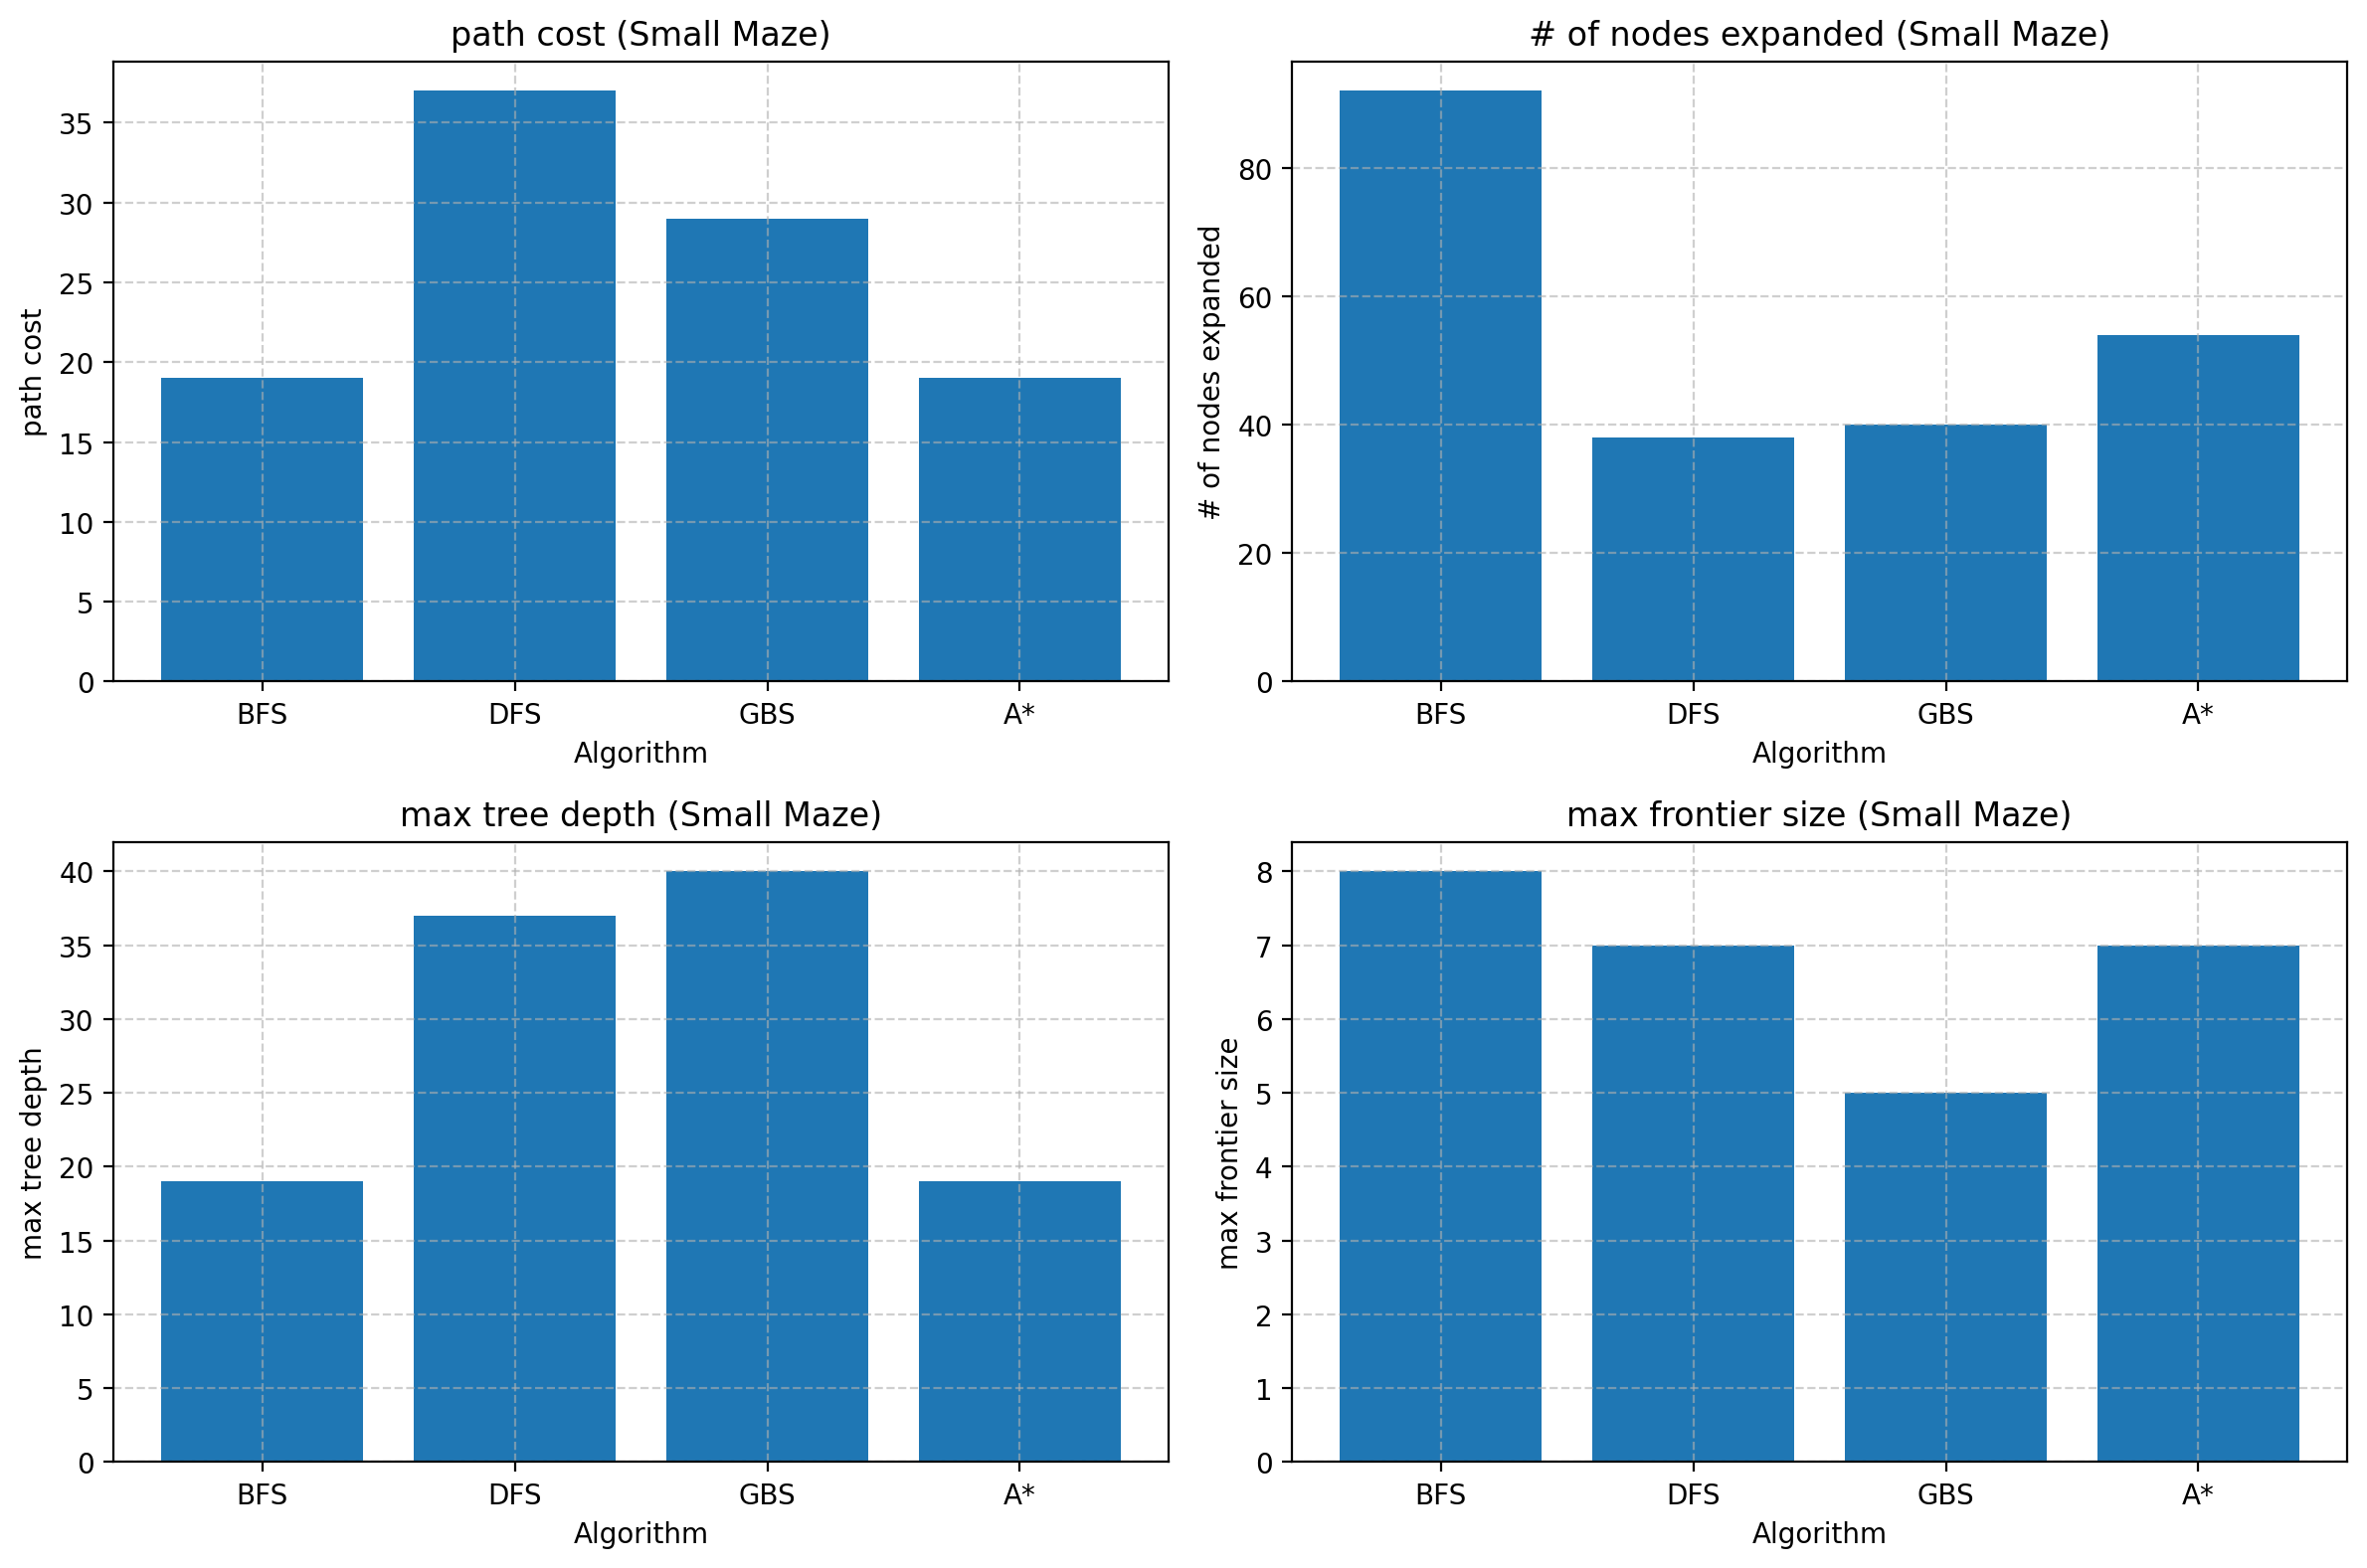

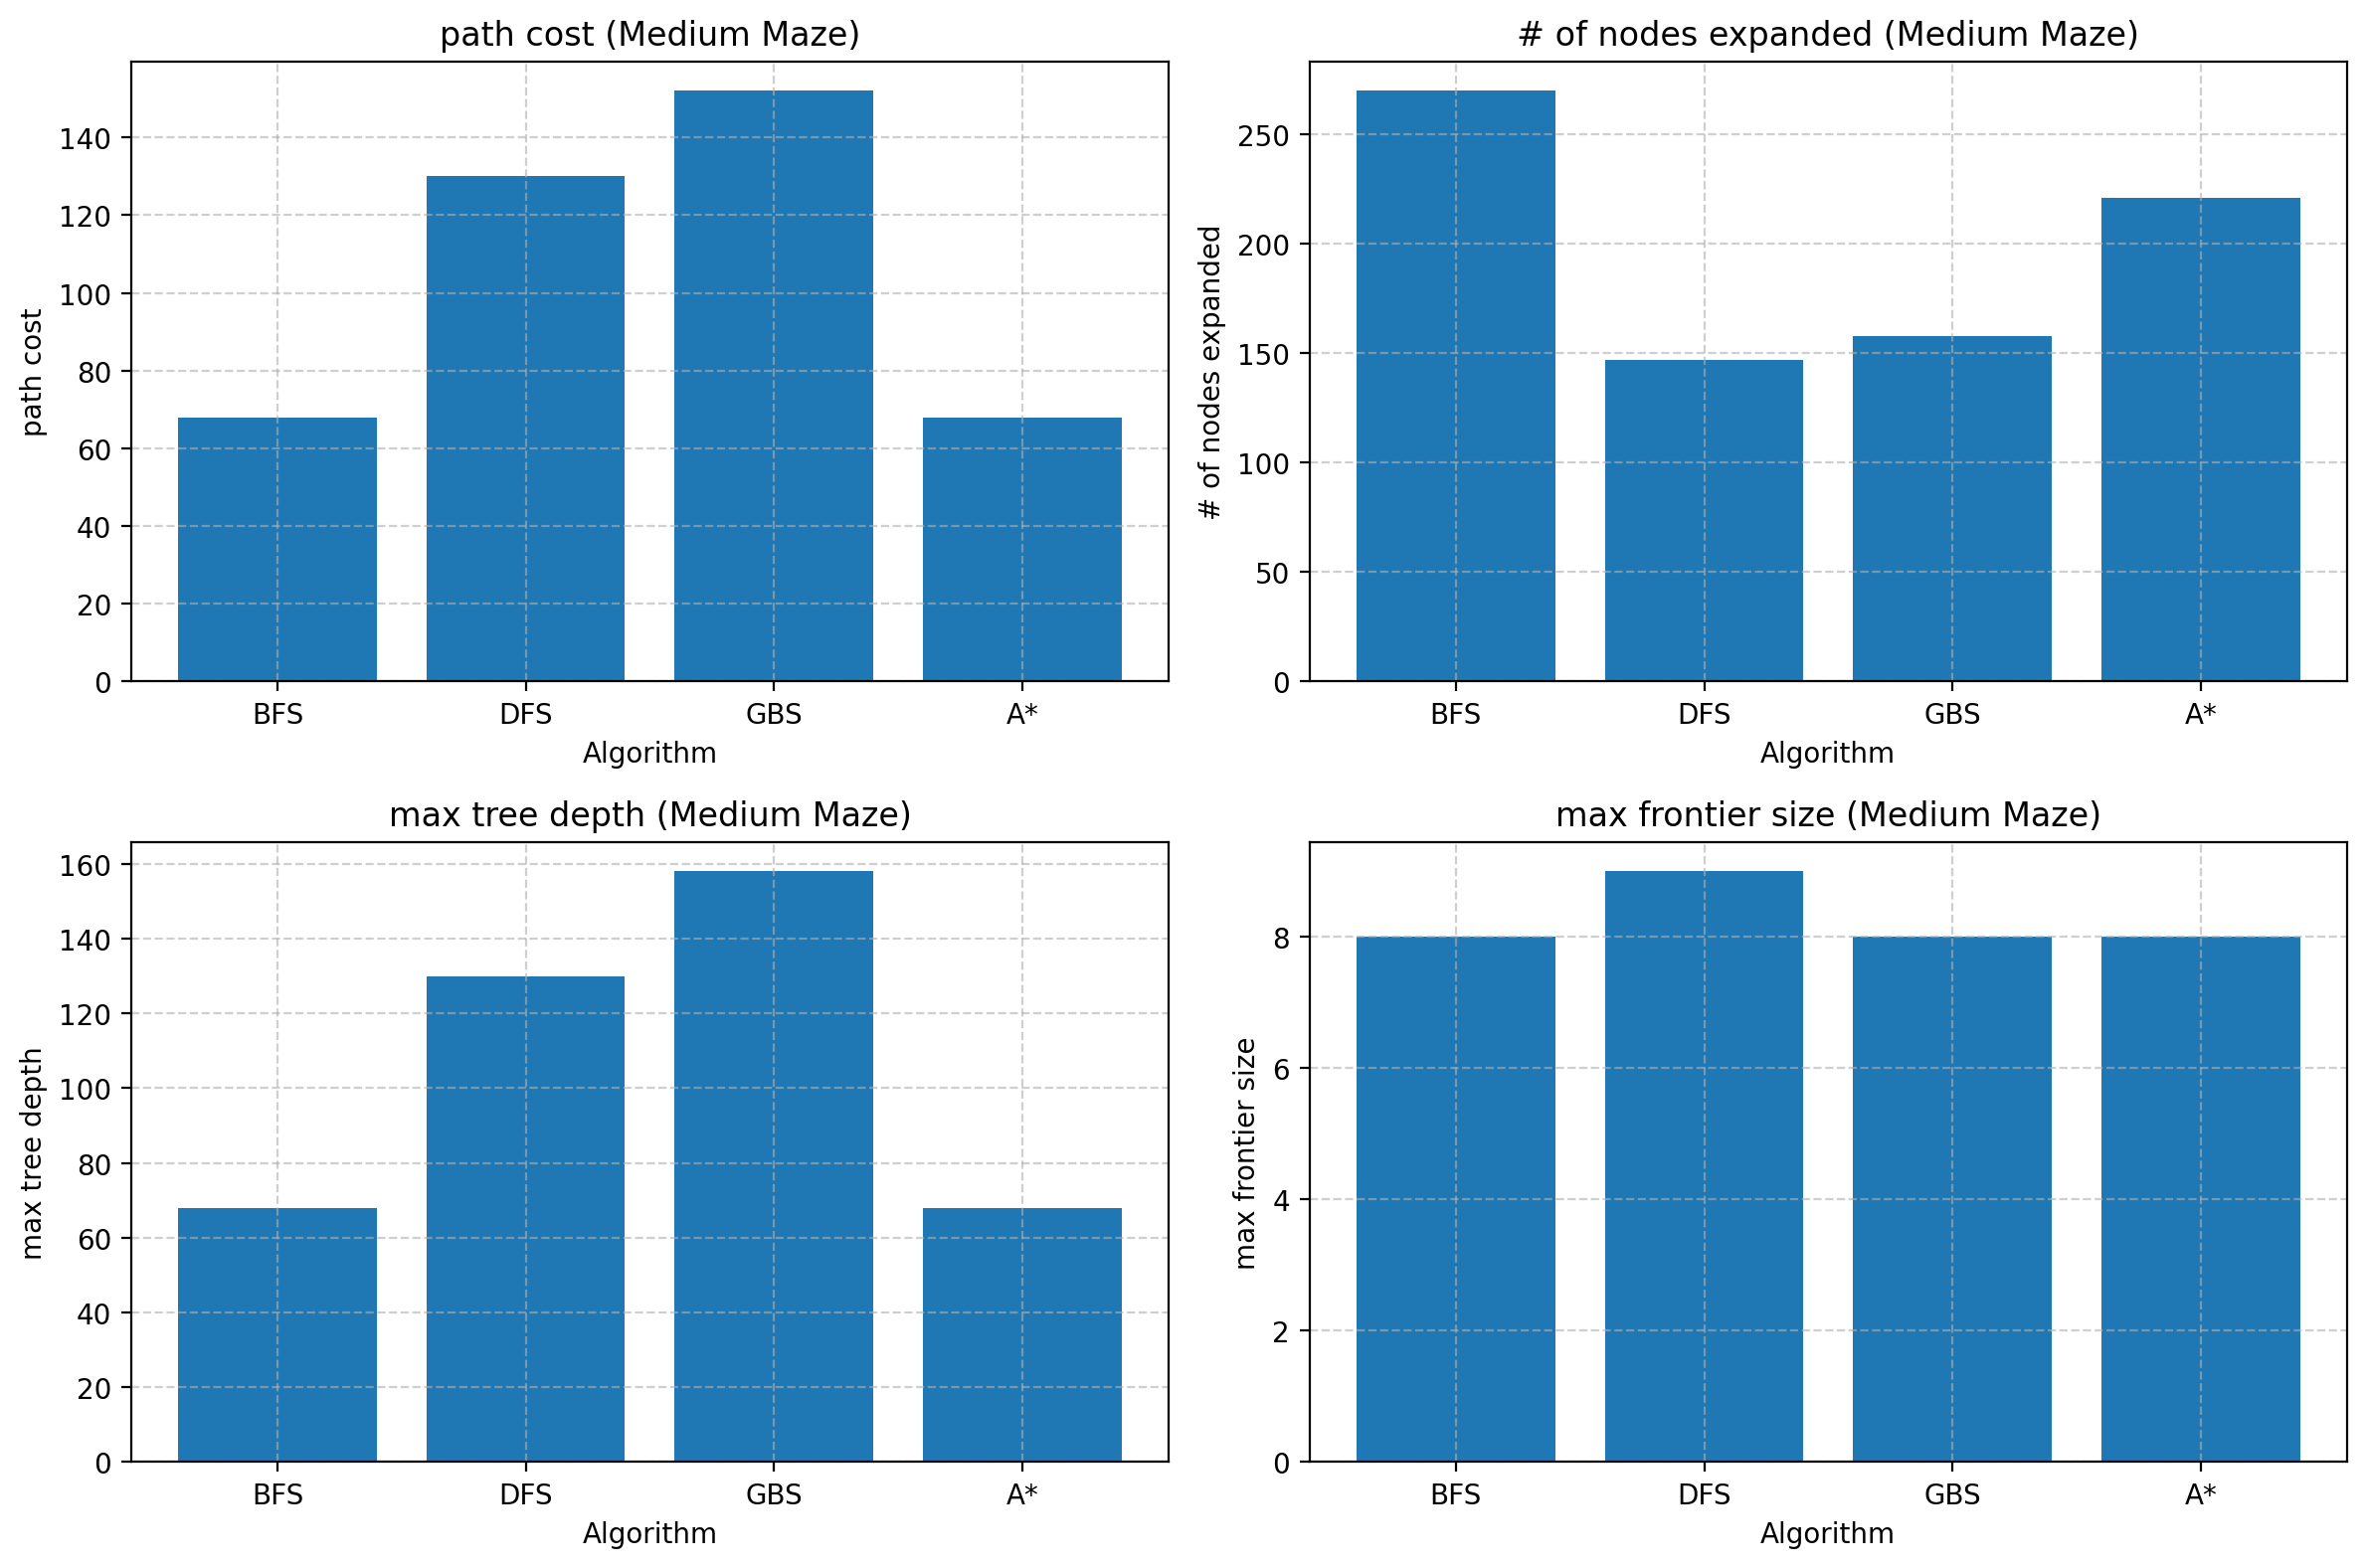

In [723]:
# Add charts
def plot_comparison(df, maze_name):
    df_maze = df[df["maze"] == maze_name]

    metrics = ["path cost", "# of nodes expanded", "max tree depth", "max frontier size"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sub_df = df_maze[df_maze[metric] != "*"]
        axes[i].bar(sub_df["algorithm"], sub_df[metric])
        axes[i].set_title(f"{metric} ({maze_name})")
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel("Algorithm")
        axes[i].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()


# --- Vẽ biểu đồ cho từng maze ---
for maze_name in df_all["maze"].unique():
    plot_comparison(df_all, maze_name)

Discuss the most important lessons you have learned from implementing the different search strategies.

In [724]:
# Add discussion

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [725]:
# Your code/answer goes here

### Multiple Goals
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [726]:
# Your code/answer goes here

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment.

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [727]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [728]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [729]:
# Your code/answer goes here